# Cataract Classification Practice
Instituto Tecnológico de Monterrey
Andrés Magaña Pérez
A01067963

Para esta primera parte, importamos el drive que tiene las imágenes con las que vamos a trabajar.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path en Drive de la carpeta del dataset
dataset_path = "/content/drive/My Drive/AI_Aplicaciones_Avanzadas/cataract_classification/output"

Mounted at /content/drive


In [3]:
# Con este comando vemos lo que tiene la carpeta que acabamos de importar.

!ls '/content/drive/My Drive/AI_Aplicaciones_Avanzadas/cataract_classification/output'

test  train  val


En el siguiente paso vamos a importar las librerías que necesitamos para hacer la práctica.

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16

# Configuramos los parámetros de ImageDataGenerator
- rescale - redimensiona las imágenes en una escala de 0 a 255.
- rotation_range - el rango de rotación que puede aplicar.
- width_shift_range - cambios horizontales aleatorios.
- height_shift_range - cambios verticales aleatorios.
- shear_range - crea un estilo de distorsión aleatoria.
- zoom_range - zooms aleatorios en las imágenes.
- horizontal_flip - cambia la imagen horizontalmente con un 50% de probabilidad.


In [21]:
# Generamos variables para guardar los paths de los diferentes folders (train, validation, testing)
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# Creamos una instancia de ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=95,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

Hacemos un llamado a la instancia anteriormente realizada con el dataset de nuestras imágenes:

In [22]:
# Cargamos las imágenes del directorio drive a la instancia del ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(416, 416),  # Escala las imágenes a su tamaño 416x416
    batch_size=32, # Aquí configuramos el tamaño del batch que vamos a manejar
    class_mode='binary',  # Puede ser binario o categórico dependiendo del problema
    subset="training", # especificamos que este va a ser nuestro grupo de entrenamiento
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 245 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [60]:
# Procesamos las imágenes por partes, no todas al mismo tiempo. Manejamos un batch de 32 imágenes.
# Con next obtenemos la imagen de cada valor, con su label correspondiente
train_gen_images, train_gen_labels = next(train_generator)

# Seleccionamos 3 imágenes para mostrar con sus labels correspondientes
train_images = train_gen_images[:3]
train_labels = train_gen_labels[:3]

print(len(train_images))
print(len(train_labels))

3
3


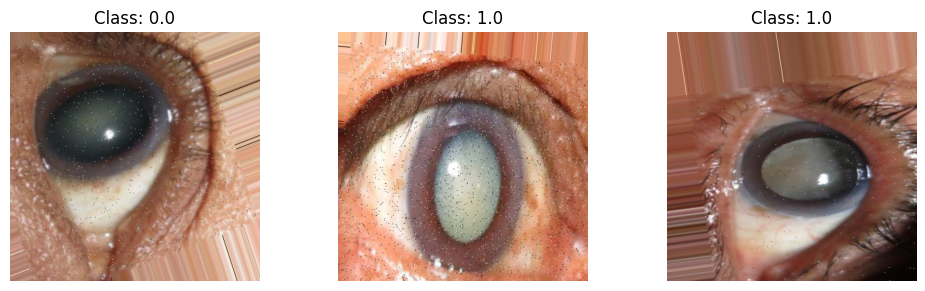

In [61]:
# Utilizamos matplotlib para mostrar las imágenes
plt.figure(figsize=(10, 3))

for i, (img, label) in enumerate(zip(train_images, train_labels), start=1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Creamos el modelo CNN

Para el modelo de Convolutional Neural Network, utilizamos una arquitectura llamada VGG16. Esta arquitectura proviene de *Visual Geometry Group* (VGG) de Oxford. En general las arquitecturas de VGG son bastante conocidas en el área de Visión Computacional y Deep Learning.

Cargamos un modelo de VGG16 que proviene de tensorflow, y ponemos los siguientes atributos:
* **weights:** cargamos pesos preentrenados que provienen de *ImageNet*, un dataset muy famoso para clasificación de imágenes con deep learning.
* **include_top:** este parámetro hace referencia a que la capa de hasta arriba completamente conectada, no debe de ser incluida. Esto es útil para problemas de extracción de características.
* **input_shape:** el tamaño de los inputs, que en este caso es el de nuestras imágenes, 416x416, y recibe los 3 colores RGB.

In [39]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

58889256/58889256 [==============================] - 1s 0us/step


A continuación ponemos el atributo **trainable** = false del model que acabamos de realizar. Esto lo que hace es que en todos los pesos en las capas durante entrenamiento no serán actualizados. Todo esto se realiza con el propósito de mantener las características preentrenadas y evitar **overfitting**.

In [40]:
base_model.trainable = False

En el siguiente bloque declaramos el modelo con VGG16:
* **Flatten layer:** el modelo VGG16 regresa outputs multidimensionales (un tensor 3D), por lo que necesitamos transformalo en un output unidimensional (un vector)
* **Primera Dense layer:** una capa densa completamente conectada con 128 neuronas y una función de activación Relu que ayuda a eliminar la linearidad. Esta capa se utiliza para aprender del vector anteriormente creado.
* **Segunda Dense layer:** la capa de outputs. Utilizamos solamente una neurona ya que es un problema binario (0 o 1). De la misma forma utilizamos la funcion de activación sigmoid porque es un problema binario el cual regresa 0 o 1.

Explicándolo de otra forma. Las Convolutional Layers se encargan de extraer diferentes características de las imágenes, como esquinas, texturas, etc. Entre más capas haya, más abstractas se vuelven estas características. Estas las va aprendiendo y las va dejando en tensores, que son de 3 dimensiones. Las capas densas se utilizan para seguir aprendiendo y después realizar las predicciones. Para que las características aprendidas pasen de la confolutional layers a las dense layers se utiliza la capa flatten, que convierte los tensores en un vector y que este pueda ser utilizado por las capas densas.

In [42]:
model = Sequential([
    # VGG16 model
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

El **optimizador** se utiliza para reducir la función de pérdida (loss). En este caso utilizamos * "Adaptive Moment Estimation" * o Adam como optimizador. Utilizamos este optimizador porque tiene bastante buen performance en múltiples tareas y es menos sensible a los cambios que se hagan en los hiperparámetros.

La función de **loss** se le conoce también como función de objetivo, y se utiliza para saber qué tan bien son las predicciones con las verdaderas etiquetas. Para la función de **loss**, utilizamos *binary_crossentropy* ya que es un problema de clasificación binario. Esta da un resultado de presencia o ausencia de una clase. Otras funciones de loss como Mean Square Error o Categorical Crossentropy son utilizadas para otro tipos de tareas, específicamente Categorical Crossentropy se utiliza para clasificación de más de una clase.

Por último, las **métricas** se utilizan para medir el performance del modelo. En este caso utilizamos accuracy el cual se enfoca en calcular el porcentaje de predicciones correctas. Otro tipo de métricas se llegan a utilizar con datasets desbalanceados. Ya que en esta práctica estamos aprendiendo por primera vez cómo hacer un modelo de Machine Learning, utilizamos accuracy, además de que estamos utilizando un data set balanceado.

In [43]:
model.compile(optimizer="adam" ,
              loss="binary_crossentropy" ,
              metrics = ['accuracy'] )

A continuación generamos el entrenamiento del modelo con nuestro set de training ya preprocesado y aumentado. Ponemos 10 épocas de aprendizaje y determinamos el validation data que utilizará el modelo que será nuestro set de validación.

In [44]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

Epoch 1/10
8/8 [==============================] - 742s 95s/step - loss: 4.4326 - accuracy: 0.4857 - val_loss: 1.1474 - val_accuracy: 0.4938
Epoch 2/10
8/8 [==============================] - 705s 90s/step - loss: 1.9380 - accuracy: 0.5429 - val_loss: 0.4844 - val_accuracy: 0.7407
Epoch 3/10
8/8 [==============================] - 734s 95s/step - loss: 0.7824 - accuracy: 0.6898 - val_loss: 0.2930 - val_accuracy: 0.8765
Epoch 4/10
8/8 [==============================] - 735s 94s/step - loss: 0.6863 - accuracy: 0.7265 - val_loss: 0.5185 - val_accuracy: 0.7901
Epoch 5/10
8/8 [==============================] - 735s 95s/step - loss: 0.5530 - accuracy: 0.7959 - val_loss: 0.7965 - val_accuracy: 0.7284
Epoch 6/10
8/8 [==============================] - 734s 95s/step - loss: 0.6068 - accuracy: 0.7878 - val_loss: 0.2918 - val_accuracy: 0.9012
Epoch 7/10
8/8 [==============================] - 735s 94s/step - loss: 0.4751 - accuracy: 0.8082 - val_loss: 0.2195 - val_accuracy: 0.9136
Epoch 8/10
8/8 [====

En la siguiente sección graficamos la pérdida y exactitud de los datos de entrenamiento y validación. Lo que buscamos es que en cada época se reduzca la pérdida y aumente la exactitud de los datos de entrenamiento. Con los parámetros de validación buscamos que la pérdida y exactitud se reduzca y aumente respectivamente, y que en un punto se estabilice.

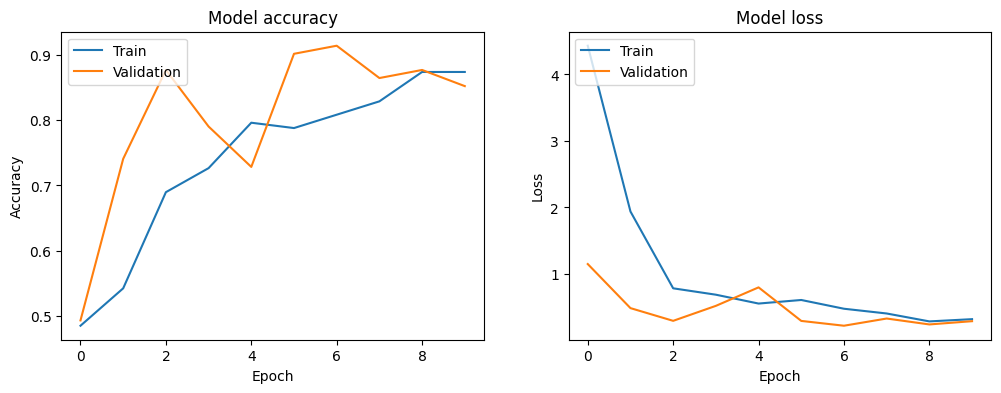

In [46]:
# Plot precisión de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Probamos el modelo con nuestros datos de testing, obteniendo un loss con el binary crossentropy y accuracy declarados en el compilador del modelo.

In [47]:
test_loss, test_accuracy = model.evaluate(test_generator)

3/3 [==============================] - 188s 59s/step - loss: 0.4461 - accuracy: 0.8452


Obtenemos los labels e imágenes del test generator, y utilizamos estas para predecir con nuestro modelo.

In [49]:
# Ya que utilizamos el test generator en la línea anterior, lo reseteamos para volverlo a utilizar.
test_generator.reset()

test_x, test_y = next(test_generator)
predictions = model.predict(test_x)
# En esta parte convertimos las probabilidades en 0 y 1 y las volvemos un vector
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

1/1 [==============================] - 74s 74s/step


In [53]:
# Creamos una lista llamada labels con los nombres de las clases
labels = list(test_generator.class_indices.keys())

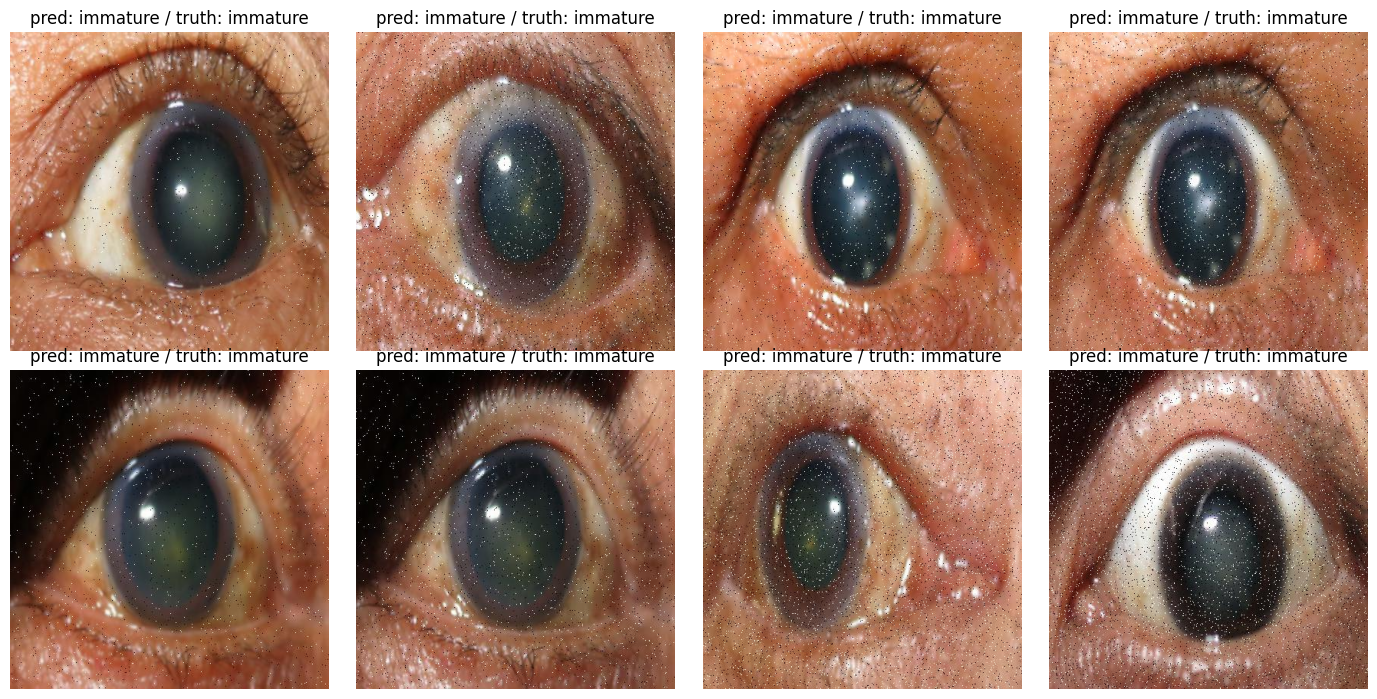

In [58]:
# Hacemos un plot de nuestras predicciones con los valores reales de los labels
plt.figure(figsize=(14, 7))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title('pred: %s / truth: %s' % (labels[predicted_classes[i]], labels[int(test_y[i])]))
    plt.imshow(test_x[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

1/1 [==============================] - 42s 42s/step


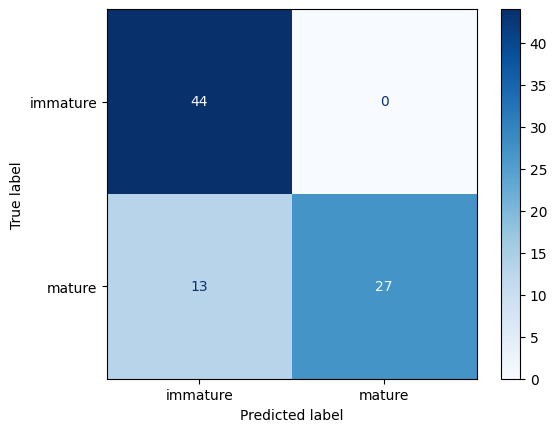

In [59]:
# Volvemos a resetear el generador y obtenemos una lista de las predicciones con las clases verdaderas
test_generator.reset()
predictions = []
true_classes = []

for i in range(len(test_generator)):
    test_x, test_y = next(test_generator)
    preds = model.predict(test_x)
    predictions.extend(preds)
    true_classes.extend(test_y)

# Utilizamos numpy para convertir las predicciones a arreglos
predictions = np.array(predictions).flatten()
true_classes = np.array(true_classes)

# Convertimos las imágenes en 0 y 1 (binario)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Generamos la matríz de confusión con Scikit Learn
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

# Mostramos la matríz de confusión
disp.plot(cmap=plt.cm.Blues)
plt.show()